In [1]:
from IPython.display import clear_output
import SALib
clear_output()
print("Everything imported!")

Everything imported!


In [ ]:
%matplotlib inline
from SALib.sample import saltelli
from model import CityModel
from agent import CarAgent
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [12]:
problem = {
    'num_vars': 4,
    'names': ['max_car_agents', 'max_velocity', 'tolerance', 'green_light_duration'],
    'bounds': [[20, 200], [1, 10], [0, 1], [2,8]]
}
model_reporters = {"average_congestion": lambda m: m.get_average_congestion()}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 20
max_steps = 300
distinct_samples = 500

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)
# print(param_values)

batch = BatchRunner(CityModel, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=problem['names'])
data['Run'], data['average_congestion'] = None, None
iteration_data= []

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals[0] = int(vals[0])
        vals[1] = int(vals[1])
        vals[3] = int(vals[3])
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count # Don't know what causes this, but iteration number is not correctly filled
        data.iloc[count, 0] = vals[0]
        data.iloc[count, 1] = vals[1]
        data.iloc[count, 2] = vals[2]
        data.iloc[count, 3] = vals[3]
        data.iloc[count, 4] = iteration_data[0]
        data.iloc[count, 5] = iteration_data[1]
    
        count += 1

        clear_output()
        # print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
    print("replicate:", i)
    data.to_csv(f'sa_data_Daan{i}.csv')

KeyboardInterrupt: 

In [ ]:
data.to_csv("dataDaan.csv")

In [6]:
Si_average_congestion = sobol.analyze(problem, data['average_congestion'].values, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
max_car_agents 0.925654 0.644202 0.828356 0.631642
max_velocity -0.004298 0.775299 0.865277 0.980942
tolerance 0.030707 0.500153 0.445151 0.769310
green_light_duration 0.279726 0.621679 0.717078 0.511654

Parameter_1 Parameter_2 S2 S2_conf
max_car_agents max_velocity -1.063007 1.059340
max_car_agents tolerance -1.053258 1.097073
max_car_agents green_light_duration -0.598038 1.090878
max_velocity tolerance -0.076375 1.260587
max_velocity green_light_duration -0.016999 1.209004
tolerance green_light_duration 0.841866 1.554827


In [7]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

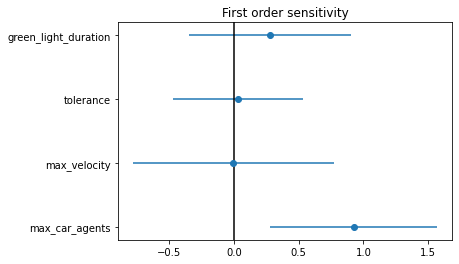

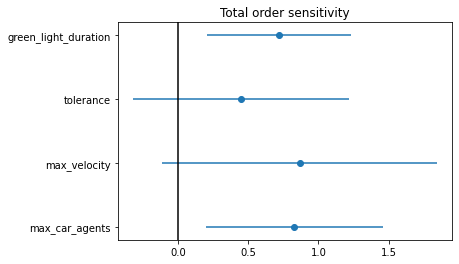

In [11]:
# First order
plot_index(Si_average_congestion, problem['names'], '1', 'First order sensitivity')
plt.show()

# Total order
plot_index(Si_average_congestion, problem['names'], 'T', 'Total order sensitivity')
plt.show()

In [12]:
data = {}

for i, var in enumerate(problem['names']):
    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
    # Keep in mind that wolf_gain_from_food should be integers. You will have to change
    # your code to acommodate for this or sample in such a way that you only get integers.
    if var in ['max_car_agents', 'max_velocity', 'green_light_duration']:
        samples = np.linspace(*problem['bounds'][i], num=distinct_samples, dtype=int)
    
    batch = BatchRunner(CityModel, 
                        max_steps=max_steps,
                        iterations=replicates,
                        variable_parameters={var: samples},
                        model_reporters=model_reporters,
                        display_progress=True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()

9it [00:09,  1.02s/it]
9it [00:16,  1.81s/it]
9it [00:13,  1.52s/it]
9it [00:10,  1.18s/it]


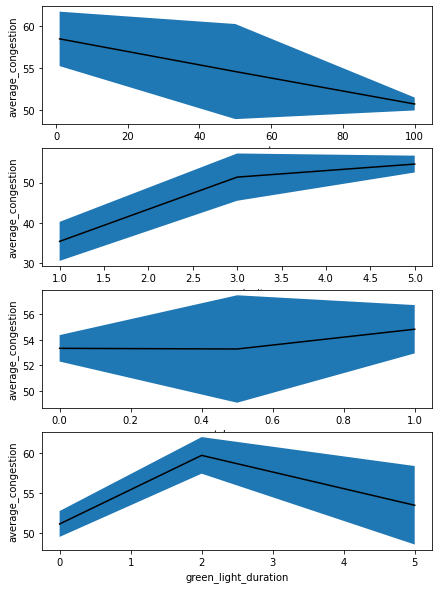

In [13]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(4, figsize=(7, 10))
    
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(axs[i], data[var], var, param, i)


plot_all_vars(data, 'average_congestion')
plt.show()